# 测试网络

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from six.moves import range
from RNNCell_diy import diyLSTMCell
from six.moves import cPickle as pickle

%matplotlib inline

读取训练数据

In [2]:
pfile = './concat_image_valid_test_data.pickle'
with open(pfile, "rb") as f:
    valid_test_data = pickle.load(f)
test_dataset = valid_test_data["test_dataset"]
test_dataset.shape = test_dataset.shape + (1,)
test_labels = valid_test_data["test_labels"]

In [3]:
cdic = {"a":0, "b":1, "c":2, "d":3, "e":4, "f":5, "g":6, "h":7, "i":8, "j":9, "remain":10}
cdic_r = {}
for key, value in cdic.items():
    cdic_r[value] = key

In [4]:
image_size_h = 56
image_size_w = 112
num_channels = 1

网络结构

In [5]:
kernel_size = 5
pooling_size = 2
channels_one = 12
channels_two = 32
hidden1_size = 300
hidden2_size = 260
rnn_num_nodes = 260
rnn_num_layers = 3


graph = tf.Graph()
with graph.as_default():
    #input data
    tf_test_dataset = tf.placeholder(tf.float32,shape=(1, image_size_h, image_size_w, num_channels))
    tf_rnn_input = tf.placeholder(tf.int32,shape=[1])
    
    #variables
    layer_weight1 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, num_channels, channels_one],stddev=0.1))
    layer_biases1 = tf.Variable(tf.zeros([channels_one]), name="bias1")
    
    layer_weight3 = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, channels_one, channels_two], stddev=0.1))
    layer_biases3 = tf.Variable(tf.constant(1.0, shape=[channels_two]), name="bias3")
    
    neuron_num = ((((image_size_h-pooling_size)//pooling_size+1-kernel_size+1-pooling_size)//pooling_size+1)**2)*channels_two
    layer_weight5 = tf.Variable(tf.truncated_normal([neuron_num, hidden1_size], stddev=0.1))
    layer_biases5 = tf.Variable(tf.constant(1.0, shape=[hidden1_size]), name="bias5")
    
    layer_weight6 = tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size], stddev=0.1))
    layer_biases6 = tf.Variable(tf.constant(1.0, shape=[hidden2_size]), name="bias6")
    
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([rnn_num_nodes, len(cdic)], -0.1, 0.1))
    b = tf.Variable(tf.zeros([len(cdic)]), name="bias_o")
    
    # Model
    def conv_model(data):
        conv = tf.nn.conv2d(data, layer_weight1, [1,1,1,1], padding="SAME")+layer_biases1
        pooling = tf.nn.relu(tf.nn.max_pool(conv, [1,2,4,1], [1,2,4,1], padding="VALID"))
        conv = tf.nn.conv2d(pooling, layer_weight3, [1,1,1,1], padding="VALID")+layer_biases3
        pooling = tf.nn.relu(tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding="VALID"))
        shape = pooling.get_shape().as_list()
        reshape = tf.reshape(pooling,[shape[0],shape[1]*shape[2]*shape[3]])
        hidden1 = tf.matmul(reshape, layer_weight5)+layer_biases5
        hidden2 = tf.nn.relu(tf.matmul(hidden1, layer_weight6)+layer_biases6)
        return hidden2
    
    def rnn_model1(input_data):
        cell_list = []
        for i in range(rnn_num_layers):
            rnn_cell = tf.contrib.rnn.BasicLSTMCell(rnn_num_nodes)
            cell_list.append(rnn_cell)
        rnn_cells = tf.contrib.rnn.MultiRNNCell(cell_list)
        with tf.variable_scope("rnn1/rnn"):
            rnn_outputs, rnn_state = rnn_cells(input_data, rnn_cells.zero_state(1,tf.float32))
        return rnn_outputs, rnn_state
            
    def rnn_model2(input_data):

        cell_list = []
        for i in range(rnn_num_layers):
            rnn_cell = tf.contrib.rnn.BasicLSTMCell(rnn_num_nodes)
            cell_list.append(rnn_cell)
        rnn_cells = tf.contrib.rnn.MultiRNNCell(cell_list)
        with tf.variable_scope("saved_state"):
            saved_output = tf.get_variable("saved_output", [1, rnn_cells.output_size], initializer=tf.constant_initializer(0.0),
                                           trainable=False)
#             saved_state_tuple = tuple([tf.get_variable("saved_state_%d"%i, [1, rnn_cells.state_size[i]], 
#                                             initializer=tf.constant_initializer(0.0),
#                                             trainable=False) for i in range(len(rnn_cells.state_size))])
            indexlist = tf.contrib.framework.nest.flatten(rnn_cells.state_size)
            state_variables = []
            for i in range(len(indexlist)):
                state_variables.append(tf.get_variable("saved_state_%d"%i ,[1, indexlist[i]], 
                                            initializer=tf.constant_initializer(0.0),
                                            trainable=False))
            saved_state_tuple = tf.contrib.framework.nest.pack_sequence_as(rnn_cells.state_size,state_variables)
        with tf.variable_scope("rnn2/rnn"):
            rnn_output, rnn_state = rnn_cells(input_data, saved_state_tuple)
        return rnn_output, rnn_state, rnn_cells
    
    def update_state_and_out_op(state_variables, new_states, output_variable, new_output):
        update_state = tf.contrib.framework.nest.map_structure(
            lambda state, var: tf.assign(var, state),
            new_states,
            state_variables,
            check_types=False)
        updates = tf.contrib.framework.nest.flatten((update_state, output_variable.assign(new_output)))
        return tf.tuple(updates)

    conv_out = conv_model(tf_test_dataset)
    rnn_output1, rnn_state1 = rnn_model1(conv_out)
    
    
    rnn_output2, rnn_state2, rnn_cells = rnn_model2(tf.one_hot(tf_rnn_input, len(cdic)))
    logits = tf.matmul(rnn_output2, w) + b
    
    tf.get_variable_scope().reuse_variables()
    with tf.variable_scope("saved_state"):
        saved_output = tf.get_variable("saved_output")
        indexlist = tf.contrib.framework.nest.flatten(rnn_cells.state_size)
        state_variables = []
        for i in range(len(indexlist)):
            state_variables.append(tf.get_variable("saved_state_%d"%i))
        saved_state_tuple = tf.contrib.framework.nest.pack_sequence_as(rnn_cells.state_size,state_variables)
    
    zero_ouput = tf.zeros([1, rnn_cells.output_size])
    zero_state_init = rnn_cells.zero_state(1,tf.float32)
    
        
    # Predictions for the training, validation, and test data.
    test_prediction = tf.nn.softmax(logits)
    
    #update state
    init_rnn2_with_rnn1 = update_state_and_out_op(saved_state_tuple, rnn_state1, saved_output, rnn_output1)
#     update_state_and_output = update_state_and_out_op(saved_state_tuple, rnn_state, saved_output, rnn_output)
    update_state_and_output2 = update_state_and_out_op(saved_state_tuple, rnn_state2, saved_output, rnn_output2)
    reset_state_and_ouptut = update_state_and_out_op(saved_state_tuple, zero_state_init, saved_output, zero_ouput)
    
    #model saver
    saver = tf.train.Saver(tf.trainable_variables())


In [6]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def chara(prediction):
    return cdic_r[np.argmax(prediction,1)[0]]

INFO:tensorflow:Restoring parameters from model/model.ckpt
[[ 0.09972374  0.10065973  0.09723981  0.09815057  0.09946471  0.09809557
   0.09889288  0.09501392  0.10071955  0.0998314   0.01220819]]
[[ 0.09877535  0.09670686  0.09810406  0.09713472  0.09703243  0.0990522
   0.09830394  0.0947701   0.09951524  0.09625074  0.02435436]]
[[ 0.05086475  0.0500524   0.0527135   0.05169874  0.05104504  0.05283936
   0.05089306  0.05072215  0.05130189  0.04865319  0.48921594]]


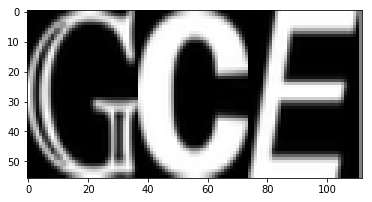

ii
[[ 0.09972374  0.10065973  0.09723981  0.09815057  0.09946471  0.09809557
   0.09889288  0.09501392  0.10071955  0.0998314   0.01220819]]
[[ 0.09877535  0.09670686  0.09810406  0.09713472  0.09703243  0.0990522
   0.09830394  0.0947701   0.09951524  0.09625074  0.02435436]]
[[ 0.05086475  0.0500524   0.0527135   0.05169874  0.05104504  0.05283936
   0.05089306  0.05072215  0.05130189  0.04865319  0.48921594]]


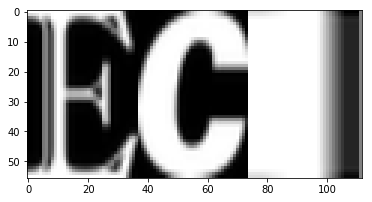

ii
[[ 0.09972374  0.10065973  0.09723981  0.09815057  0.09946471  0.09809557
   0.09889288  0.09501392  0.10071955  0.0998314   0.01220819]]
[[ 0.09877535  0.09670686  0.09810406  0.09713472  0.09703243  0.0990522
   0.09830394  0.0947701   0.09951524  0.09625074  0.02435436]]
[[ 0.05086475  0.0500524   0.0527135   0.05169874  0.05104504  0.05283936
   0.05089306  0.05072215  0.05130189  0.04865319  0.48921594]]


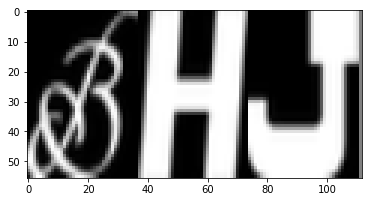

ii
[[ 0.09972374  0.10065973  0.09723981  0.09815057  0.09946471  0.09809557
   0.09889288  0.09501392  0.10071955  0.0998314   0.01220819]]
[[ 0.09877535  0.09670686  0.09810406  0.09713472  0.09703243  0.0990522
   0.09830394  0.0947701   0.09951524  0.09625074  0.02435436]]
[[ 0.05086475  0.0500524   0.0527135   0.05169874  0.05104504  0.05283936
   0.05089306  0.05072215  0.05130189  0.04865319  0.48921594]]


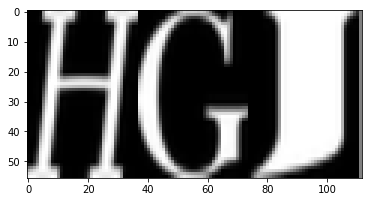

ii
[[ 0.09972374  0.10065973  0.09723981  0.09815057  0.09946471  0.09809557
   0.09889288  0.09501392  0.10071955  0.0998314   0.01220819]]
[[ 0.09877535  0.09670686  0.09810406  0.09713472  0.09703243  0.0990522
   0.09830394  0.0947701   0.09951524  0.09625074  0.02435436]]
[[ 0.05086475  0.0500524   0.0527135   0.05169874  0.05104504  0.05283936
   0.05089306  0.05072215  0.05130189  0.04865319  0.48921594]]


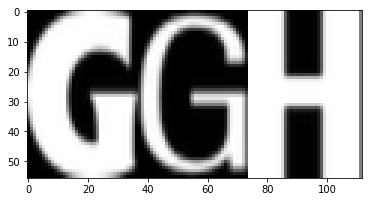

ii


In [7]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess,"model/model.ckpt")
    index = np.random.randint(0,len(test_dataset),5)
    batch_test = test_dataset[index]
    for i in range(5):
        feed_dict = {}
        feed_dict[tf_test_dataset] = batch_test[[i]]
#         prediction,_ = sess.run([test_prediction, update_state_and_output], feed_dict=feed_dict)
        sess.run(init_rnn2_with_rnn1, feed_dict=feed_dict)
        sentence = ""
        feed = cdic["d"]
        feed_dict = {}
        feed_dict[tf_rnn_input] = [feed]
        prediction,_ = sess.run([test_prediction, update_state_and_output2], feed_dict=feed_dict)
        print(prediction)
        while chara(prediction) != "remain":
            sentence += chara(prediction)
            feed_dict = {}
            feed_dict[tf_rnn_input] = [cdic[chara(prediction)]]
            prediction,_ = sess.run([test_prediction,update_state_and_output2], feed_dict=feed_dict)
            print(prediction)
        plt.imshow(batch_test[i].reshape(batch_test[i].shape[:-1]), cmap=plt.cm.gray)
        plt.show()
        print(sentence)
        sess.run([reset_state_and_ouptut])

        
        